## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

import numpy as np
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv',  index_col=[0], parse_dates=[0])

In [3]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()

In [4]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Вывод: загрузили данные, провели ресемплирование по часу

# 2. Анализ

In [5]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
taxi.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


In [7]:
taxi.sample(5)

,num_orders
datetime,
2018-05-20 20:00:00,74
2018-07-13 02:00:00,153
2018-03-12 08:00:00,75
2018-06-19 23:00:00,86
2018-08-31 05:00:00,78


In [8]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [9]:
taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [10]:
taxi.duplicated().sum()

4165

In [11]:
taxi.isnull().sum()

num_orders    0
dtype: int64

Виртуализируем временной ряд:

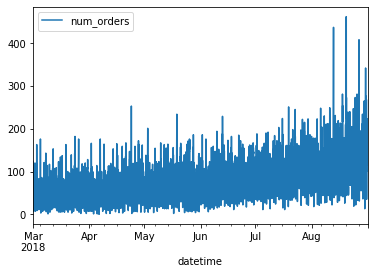

In [12]:
taxi.plot()

Построим график сезонности:

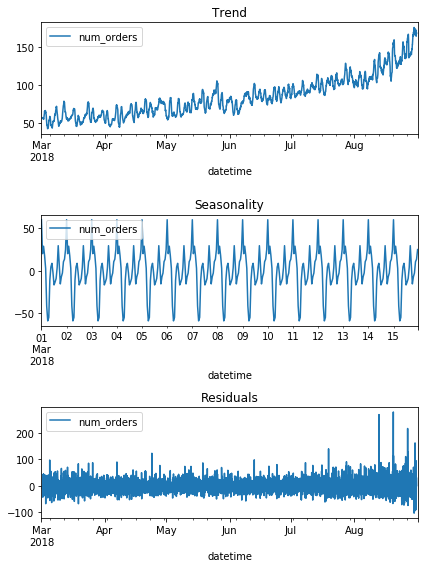

In [13]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Вывод: 

1. пропусков не обнаружено

2. датасет составляют 2 столбца - время и число заказов

# 3. Обучение

Сейчас у нас есть только целевой признак - число заказов и время заказа. Выведем признаки из столбца со временем заказа.

In [14]:
taxi

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [15]:
def make_features(taxi, max_lag, rolling_mean_size):
    taxi['year'] = taxi.index.year
    taxi['month'] = taxi.index.month
    taxi['day'] = taxi.index.day
    taxi['dayofweek'] = taxi.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)
        
    taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(taxi, 4, 4)
print(taxi.head())

                     num_orders  year  month  day  dayofweek  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00         124  2018      3    1          3    NaN    NaN   
2018-03-01 01:00:00          85  2018      3    1          3  124.0    NaN   
2018-03-01 02:00:00          71  2018      3    1          3   85.0  124.0   
2018-03-01 03:00:00          66  2018      3    1          3   71.0   85.0   
2018-03-01 04:00:00          43  2018      3    1          3   66.0   71.0   

                     lag_3  lag_4  rolling_mean  
datetime                                         
2018-03-01 00:00:00    NaN    NaN           NaN  
2018-03-01 01:00:00    NaN    NaN           NaN  
2018-03-01 02:00:00    NaN    NaN           NaN  
2018-03-01 03:00:00  124.0    NaN           NaN  
2018-03-01 04:00:00   85.0  124.0          86.5  


In [16]:
taxi.columns 
taxi = taxi.dropna()

train, test = train_test_split(taxi, test_size=0.1, random_state=42)

y_train = train['num_orders']
X_train = train.drop(['num_orders'], axis = 1) 

y_test = test['num_orders']
X_test = test.drop(['num_orders'], axis = 1) 

Обучим различные модели машинного обучения:

1. Дерево решений

In [17]:
decision_tree_regression = DecisionTreeRegressor(random_state=0)
parametrs = { 'max_depth': range (1,7, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

tscv = TimeSeriesSplit(n_splits=2)

grid_decision_tree_regression = GridSearchCV(decision_tree_regression, parametrs, cv=tscv)
grid_decision_tree_regression.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=0,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': range(1, 7, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split

In [18]:
grid_decision_tree_regression.best_params_

predictions_train = grid_decision_tree_regression.predict(X_train)
print( " rmse" , mean_squared_error(y_train, predictions_train)**.5)

 rmse 32.12581129565478


2. Случайный лес

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

model_forest_regression= RandomForestRegressor(random_state=12345)

parametrs = {'max_depth': range (1,8),
              'min_samples_leaf': range (1,5)}

tscv = TimeSeriesSplit(n_splits=2)

grid_forest_regression = GridSearchCV(model_forest_regression, parametrs, cv=tscv)
grid_forest_regression.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_st

In [20]:
grid_forest_regression.best_params_

predictions_train = grid_forest_regression.predict(X_train)
print( " rmse" , mean_squared_error(y_train, predictions_train)**.5)

 rmse 31.07504172024312


3. Линейная регрессия

In [21]:
linear_model = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
linear_model.fit(X_train, y_train)
predictions_train = linear_model.predict(X_train)
print( " rmse на тренировочной выборке " , mean_squared_error(y_train, predictions_train)**.5)

 rmse на тренировочной выборке  33.424999384069544


4. Catboost

In [22]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(loss_function='RMSE',  iterations=1000,  depth = 10, learning_rate=0.1, verbose=100)  
 
cat_features = ['Datetime']
 
cat.fit(X_train, y_train, verbose=10) 
 
predictions_train = cat.predict(X_train)

print( " rmse на тренировочной выборке " , mean_squared_error(y_train, predictions_train)**.5)

0:	learn: 43.0287636	total: 52.2ms	remaining: 52.1s
10:	learn: 34.2493909	total: 658ms	remaining: 59.1s
20:	learn: 31.3993267	total: 1.18s	remaining: 54.8s
30:	learn: 29.7700347	total: 1.76s	remaining: 55s
40:	learn: 28.7528442	total: 2.43s	remaining: 56.9s
50:	learn: 27.9944353	total: 3.03s	remaining: 56.3s
60:	learn: 27.4002302	total: 3.61s	remaining: 55.6s
70:	learn: 26.7789176	total: 4.2s	remaining: 55s
80:	learn: 26.0994758	total: 4.82s	remaining: 54.7s
90:	learn: 25.5243765	total: 5.51s	remaining: 55s
100:	learn: 25.1284607	total: 6.09s	remaining: 54.2s
110:	learn: 24.8000064	total: 6.58s	remaining: 52.7s
120:	learn: 24.3227934	total: 7.19s	remaining: 52.2s
130:	learn: 23.9115121	total: 7.77s	remaining: 51.5s
140:	learn: 23.3673488	total: 8.36s	remaining: 50.9s
150:	learn: 22.7920214	total: 8.95s	remaining: 50.3s
160:	learn: 22.2998671	total: 9.64s	remaining: 50.2s
170:	learn: 21.8535574	total: 10.2s	remaining: 49.6s
180:	learn: 21.2354906	total: 10.7s	remaining: 48.6s
190:	learn

5. LightGBM

In [23]:
hyper_params = {
    "max_depth": 20,
    "max_lags": 57,
    "num_leaves": 145,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0}
    
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)
predictions_train = gbm.predict(X_train, num_iteration=gbm.best_iteration_)

print( " rmse на тренировочной выборке " , mean_squared_error(y_train, predictions_train)**.5)

[1]	valid_0's l1: 33.8374	valid_0's l2: 2054.92
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's l1: 33.0623	valid_0's l2: 1963.21
[3]	valid_0's l1: 32.3298	valid_0's l2: 1883.69
[4]	valid_0's l1: 31.6238	valid_0's l2: 1808.4
[5]	valid_0's l1: 30.9708	valid_0's l2: 1740.14
[6]	valid_0's l1: 30.3326	valid_0's l2: 1673.45
[7]	valid_0's l1: 29.7445	valid_0's l2: 1615.28
[8]	valid_0's l1: 29.1836	valid_0's l2: 1558.33
[9]	valid_0's l1: 28.7102	valid_0's l2: 1508.32
[10]	valid_0's l1: 28.272	valid_0's l2: 1465.45
[11]	valid_0's l1: 27.8331	valid_0's l2: 1421.8
[12]	valid_0's l1: 27.4096	valid_0's l2: 1381.72
[13]	valid_0's l1: 27.0537	valid_0's l2: 1344.89
[14]	valid_0's l1: 26.6984	valid_0's l2: 1313.1
[15]	valid_0's l1: 26.3216	valid_0's l2: 1279.24
[16]	valid_0's l1: 26.0354	valid_0's l2: 1251.52
[17]	valid_0's l1: 25.7617	valid_0's l2: 1226.64
[18]	valid_0's l1: 25.4949	valid_0's l2: 1204.35
[19]	valid_0's l1: 25.311	valid_0's l2: 1185.95
[20]	valid_0's l1: 2

Вывод: на тренировочной выборке лучше всего себя показала модель Catboost

# 4. Тестирование

Дерево решений:

In [24]:
%%time

grid_decision_tree_regression.best_params_

predictions_test = grid_decision_tree_regression.predict(X_test)
print( " rmse" , mean_squared_error(y_test, predictions_test)**.5)

 rmse 31.92632053524737
CPU times: user 4.83 ms, sys: 33 µs, total: 4.86 ms
Wall time: 3.54 ms


Случайный лес:

In [25]:
%%time

grid_forest_regression.best_params_

predictions_test = grid_forest_regression.predict(X_test)

print( " rmse на тестовой выборке " , mean_squared_error(y_test, predictions_test)**.5)

 rmse на тестовой выборке  31.001847054864697
CPU times: user 4.81 ms, sys: 31 µs, total: 4.84 ms
Wall time: 4.28 ms


Линейная регрессия:

In [26]:
%%time

predictions_test = linear_model.predict(X_test)

print( " rmse на тестовой выборке " , mean_squared_error(y_test, predictions_test)**.5)

 rmse на тестовой выборке  31.493781164889946
CPU times: user 2.63 ms, sys: 0 ns, total: 2.63 ms
Wall time: 2.27 ms


Catboost:

In [27]:
%%time
 
predictions_test = cat.predict(X_test)
  
print( " rmse на тестовой выборке " , mean_squared_error(y_test, predictions_test)**.5)

 rmse на тестовой выборке  30.309170746510087
CPU times: user 16.4 ms, sys: 0 ns, total: 16.4 ms
Wall time: 51.8 ms


LightGBM

In [28]:
%%time 

predictions_test = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

print( " rmse на тестовой выборке " , mean_squared_error(y_test, predictions_test)**.5)

 rmse на тестовой выборке  30.397452739816327
CPU times: user 59.3 ms, sys: 0 ns, total: 59.3 ms
Wall time: 17.3 ms


Результаты исследования:

1. было проведено ресемплирование данных типа datetime

2. выделены признаки из столбца datetime для построения моделей

3. использованы различные модели машинного обучения: дерево решений, случайный лес, линейная регрессия, Catboost, LightGBM с использованием различных гиперапараметров и без них

4. Была выбрана наилучшая модель на основе RMSE -  модель LightGBM или модель Catboost, но время выполнения Catboost наиболее высокое. Все модели удовлетворяют свойству rmse < 48 на тестово выборке, поэтому для того, чтобы выбрать модель в продакшн, необходимо знать, важна ли характеристика времени и нагрузка на CPU.